## **Задача 1**

В качестве статистики будем использовать $T=\sum\limits_{i=1}^n \xi_i$. $\xi_i = I(x_i>0)$. $I(x_i>0)$ имеет распределение $Be(0.5)$ в условиях истинности гипотезы $m=0$, а $T$ тогда будет $Bin(n, 0.5)$. При альтернативе вероятность $p(\xi_i = 1) = \int\limits_0^{+\infty}\frac{1}{\sqrt{2\pi}}exp(-\frac{(x_i-m)^2}{2\sigma^2})dx_i = p(m,\sigma)$. Следовательно $T$ будет иметь распределение $Bin(n, p(m,\sigma))$. Теперь найдем $\frac{\alpha}{2}$-квантиль распределения $T$, равный $k$, из условий $\sum\limits_{i=0}^{k}C_n^i 0.5^{n} \leq\frac{\alpha}{2}$ и $\sum\limits_{i=0}^{k+1}C_n^i 0.5^{n} > \frac{\alpha}{2}$. Тогда критическая область равна $\Omega = [0, k]\cup [n-k,n]$. Мощность по по определению будет равна $W(m,\sigma) = \sum\limits_{i=0}^k C_n^i p(m,\sigma)^{i}\left(1-p(m,\sigma)\right)^{n-i}+\sum\limits_{i=n-k}^n C_n^i p(m,\sigma)^{i}\left(1-p(m,\sigma)\right)^{n-i}$.

In [ ]:
import random
import numpy as np
from scipy.special import binom
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

alpha = 0.05
n = 200

def find_cvantil(n,p,alpha):
  k = 0
  while integ(0, k, n, p) < alpha:
    k += 1
  return k-1

def integ(k1, k2, n, p):
  return sum([binom(n, k1+i)*p**(k1+i)*(1-p)**(n-k1-i) for i in range(k2-k1+1)])

def W(n, p, k):
  k = find_cvantil(n,p,alpha)
  return integ(0, k, n, p) + integ(n-k, n, n, p)

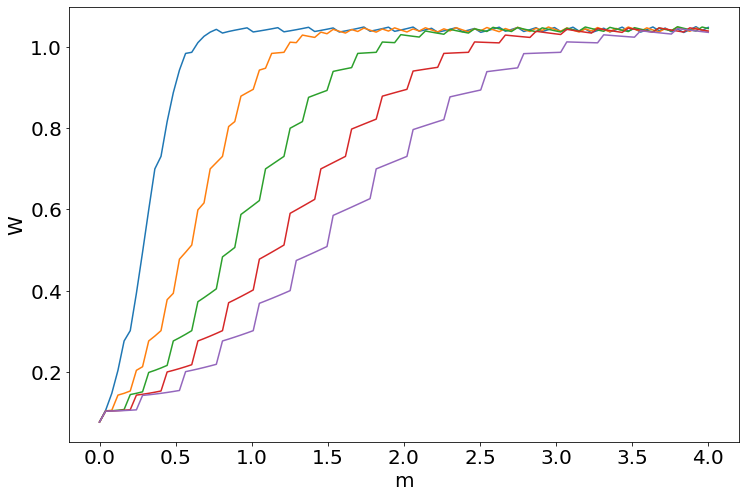

In [ ]:
alpha = 0.05

list_W = []
xx = np.linspace(0, 4, 100)
for sigma in np.linspace(4, 20, 5):
  list_cur = []
  for m in xx:
    p = quad(lambda x: norm.pdf(x, m, sigma), 0, np.inf)[0]
    k = find_cvantil(n, 0.5, alpha/2)
    list_cur.append(W(n, p, k))
  list_W.append(list_cur)

plt.figure(figsize=(12, 8))
fontsize=20

ax = plt.axes()
plt.xlabel(r"m", fontsize=fontsize)
plt.ylabel(r"W", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

for i, sigma in enumerate(np.linspace(10, 50, 5)):
  ax.plot(xx, list_W[i], label=f'std = {sigma}')

## **Задача 2**

a) При выбранном $w$ сэмплированием максимальное качество AUC. Для данной модели генерации данных оптимальным классификатором будет логистическая регрессия, поэтому смотрим AUC, после ее применения.

In [ ]:
from scipy.stats import bernoulli
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def get_data(m, n, w):
  X = norm.rvs(0, sigma, m*n).reshape(m, n)

  p_list = np.array([1/(1+np.exp(-w.dot(X[i]))) for i in range(m)])
  y = np.array([bernoulli.rvs(p, size=1)[0] for p in p_list])
  return X, y

In [ ]:
n = 10
sigma, alpha = 1, 1
w = norm.rvs(0, 1/alpha, n)
w = np.ones(n)

In [ ]:
n_sample = 3
for m2 in [10, 100, 1000, 10000, 100000, 1000000]:
  std_score = 0
  for i in range(n_sample):
    X2, y2 = get_data(m2, n, w)
    logistic = LogisticRegression()
    logistic.coef_ = w.reshape(1, -1)
    logistic.intercept_ = np.zeros(1)
    logistic.classes_ = np.array([0,1])
    y_pred = logistic.predict(X2)
    std_score += roc_auc_score(y2, y_pred)
  std_score /= n_sample
  print('m2 =', m2, ': AUC =', std_score)

m2 = 10 : AUC = 0.8456349206349206
m2 = 100 : AUC = 0.8606528213658944
m2 = 1000 : AUC = 0.8303808163023304
m2 = 10000 : AUC = 0.8423080083426889
m2 = 100000 : AUC = 0.8435476626091082
m2 = 1000000 : AUC = 0.8425161528948925


Теперь выведем это значение AUC аналитически. При $m_2\rightarrow +\infty$ значение AUC будет равно вероятности, того что случайно выбранный объект будет правильно классифицирован при данной постановке задачи. Истинные значения $y_j$ зависят от $p =\sigma(\textbf w^T\textbf x_j)$: $y_j = Be(p)$. Решение об отнесении объекта классу классификатором принимается исходя из знака $z=\textbf w^T\textbf x_j$: больше $0$ --- одному классу, меньше --- другому. Следовательно, вероятность того, что объект правильно классифицирован равна $\sigma(|\textbf w^T\textbf x_j|)$

Так как $\textbf x_j\in N(0, \sigma^2 I_n)$, то $z_j=\textbf w^T\textbf x_j\in N(0, ||w||^2\sigma^2)$.

По определению AUC равен доле пар объектов вида (объект класса $0$, объект класса $1$), которые алгоритм верно упорядочил. Численно это можно записать так:

$$AUC = \frac{\sum\limits_{i=0}^m\sum\limits_{j=0}^m I[y_i < y_j]I'[a_i < a_j]}{\sum\limits_{i=0}^m\sum\limits_{j=0}^m I[y_i < y_j]},$$

$I[y_i < y_j] = 
 \begin{cases}
   0, & y_i \geq y_j\\
   1, & y_i < y_j
 \end{cases}\quad \quad\ \quad I'[a_i < a_j] = 
 \begin{cases}
   0, & a_i > a_j\\
   0.5, & a_i = a_j\\
   1, & a_i < a_j
 \end{cases}$

где  $a_i$ --- ответ классификатора, $y_i$ --- метка класса на $i$ объекте.

 Иначе можно записать:

 $$AUC = \frac{\nu_{01}+0.5*\nu_{00}+0.5*\nu_{11}}{\nu},$$

где $\nu_{a_ia_j}$ --- количество пар вида (объект класса $0$, объект класса $1$), которые классификатор отнесс к классам $(a_i,a_j)$, а $\nu$ --- количество пар вида (объект класса $0$, объект класса $1$).

Осредним по всем перестановкам внутри группы $0$ и $1$: рассмотрим вероятностное пространство пар $\textbf z_{ij} = (z_i, z_j) = (\textbf w^T\textbf x_i, \textbf w^T\textbf x_j)$, тогда $\textbf z_{ij}\in N((0,0)^T, ||w||^2\sigma^2 I_2)$. Все пространство разделяется на $4$ области $\Omega_a$: $(z_i>0,z_j>0)$: пары, оба объекта которых классифицированы в $1$ класс, $(z_i<0,z_j>0)$ --- первый объект в $0$ класс, второй в $1$ класс, $(z_i>0,z_j<0)$ --- первый объект в $1$ класс, второй в $0$ класс, и $(z_i<0,z_j<0)$ --- оба объекта в $0$ класс. При $m_2\rightarrow +\infty$:

 $\nu = m_2\cdot E_{\textbf z}p(y_i<y_j),$

$\nu_{\textbf a}=\nu_{a_ia_j} = \nu\cdot E_{\textbf z}p(\textbf z_{ij}\in\Omega_a|y_i<y_j) = \nu\frac{E_{\textbf z}p(y_i<y_j| \textbf z_{ij}\in\Omega_a)\cdot E_{\textbf z}p(\textbf z_{ij}\in\Omega_a)}{E_{\textbf z}p(y_i<y_j)} = 0.25m_2\cdot E_{\textbf z}p(y_i<y_j| \textbf z_{ij}\in\Omega_a),$

здесь $p(\textbf z_{ij}\in\Omega_a) = 0.25$, так как $\Omega_a$ --- один из квадрантов плоскости и $\textbf z_{ij}\in N((0,0)^T, ||w||^2\sigma^2 I_2)$.
 
$AUC = \frac{1}{\nu}(\nu_{01}+0.5*\nu_{00}+0.5*\nu_{11})
=\frac{0.25}{E_{\textbf z}p(y_i<y_j)}(E_{\textbf z}p(y_i<y_j| z_i<0, z_j>0)+0.5E_{\textbf z}p(y_i<y_j| z_i<0,z_j<0)+0.5E_{\textbf z}p(y_i<y_j| z_i>0,z_j>0))$

$p(y_i<y_j) = (1-\sigma(z_i))\sigma(z_j)$

$E_{\textbf z}p(y_i<y_j) = \int\limits_{-\infty}^{+\infty}\int\limits_{-\infty}^{+\infty} (1-\sigma(t_1))\sigma(t_2)f_{\textbf z}(t_1,t_2)d t_1 d t_2$

$E_{\textbf z}p(y_i<y_j|\textbf z_{ij}\in\Omega_a) = \iint\limits_{\Omega_a} (1-\sigma(t_1))\sigma(t_2)f_{\textbf z}(t_1,t_2)d t_1 d t_2$

Таким образом, после подсчета интегралов находится максимальное значение AUC при $m_2\rightarrow +\infty$. Сделаем это численно:



In [ ]:
import math
from scipy.special import expit
from scipy.integrate import dblquad

var = multivariate_normal(mean=[0,0], cov=[[w.dot(w)*sigma**2,0],[0,w.dot(w)*sigma**2]])
fz = lambda z1, z2: var.pdf([z1,z2])
f = lambda z1, z2: (1-expit(z1))*expit(z2)*fz(z1,z2)

Pairs_01 = dblquad(f, 0, np.inf, lambda x: -np.inf, lambda x: 0)[0]
Pairs_11 = 0.5*dblquad(f, 0, np.inf, lambda x: 0, lambda x: np.inf)[0]
Pairs_00 = 0.5*dblquad(f, -np.inf, 0, lambda x: -np.inf, lambda x: 0)[0]
C = dblquad(f, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)[0]

print('max AUC =', (Pairs_01+Pairs_11+Pairs_00)/C)

max AUC = 0.8427996759255033


Аналитический результат соответсвует эмпирическим оценкам.

б) E(AUC) для разных $m_2$ при случайном выборе $w_0$: применим логистическую регрессию и усреднив посчитаем эмпирическое E(AUC).

In [ ]:
n_sample = 100
for m2 in [10, 100, 1000, 10000]:
  std_score = 0
  for i in range(n_sample):
    w = norm.rvs(0, 1/alpha, n)
    w0 = norm.rvs(0, 1/alpha, n)
    X2, y2 = get_data(m2, n, w)
    logistic = LogisticRegression()
    logistic.coef_ = w0.reshape(1, -1)
    logistic.intercept_ = np.zeros(1)
    logistic.classes_ = np.array([0,1])
    std_score += roc_auc_score(y2, logistic.predict(X2))
  std_score /= n_sample  
  print('m2 =', m2, ':  AUC =', std_score)

m2 = 10 :  AUC = 0.5007285714285715
m2 = 100 :  AUC = 0.48169743691606903
m2 = 1000 :  AUC = 0.5257851018479193
m2 = 10000 :  AUC = 0.5145152116776073


Видно, что в этом случае E(AUC) равно $0.5$.

Получим тот же результат аналитически. Если выбор $w_0$ не зависит от $w$, то результаты классификации $a_i$ и, соответсвенно, $z_i$ не зависимы с $y_i$.

$E_{\textbf z}p(y_i<y_j|\textbf z_{ij}\in\Omega_a) = E_{\textbf z}p(y_i<y_j)$

$AUC = \frac{0.25}{E_{\textbf z}p(y_i<y_j)}(E_{\textbf z}p(y_i<y_j| z_i<0, z_j>0)+0.5E_{\textbf z}p(y_i<y_j| z_i<0,z_j<0)+0.5E_{\textbf z}p(y_i<y_j| z_i>0,z_j>0)) = 0.25(1+0.5+0.5)=0.5$

## **Задача 3**

a) $m$ --- количество объектов. 

$ACC = \frac{T}{m} = \frac{TP + TN}{m} = \frac{1}{m}TP+\frac{1}{m}TN = -ASY
\left(
  \begin{array}{cc}
-\frac{1}{m} & 0  \\
0 & -\frac{1}{m}  \\
\end{array}
\right)$

б) Так как, $y_j$ не зависит от $\textbf x_j$, то наилучший прогноз буден носить чисто вероятностный характер, никак не завсиящий от $X_2$. То есть нужно определить вероятность $q$, с которой мы будем относить $\textbf x_j$ к классу $1$. 

$ACC = \frac{1}{m}TP+\frac{1}{m}TN = pq+(1-p)(1-q)=1-p-q+2pq=1-p-(1-2p)q\rightarrow \max\limits_{q}$.

Если $1-2p > 0$, то есть $p < 0.5$ то $q=0$ и $ACC = 1-p$.

Если $1-2p < 0$, то есть $p > 0.5$ то $q=1$ и $ACC = p$.

Если $1-2p = 0$, то есть $p = 0.5$ то не важно чему равно $q$, $ACC = 0.5$.

Таким образом, наилучшим прогнозом в терминах ACC будет $\hat y_2 = Be(q)$, где $q = I[p>0.5]$

В общем случае надо минимизровать:

$ASY(\textbf P) = P_{00}(1-p)(1-q) + P_{10}p(1-q) + P_{01}(1-p)q + P_{11}pq = [P_{00}(1-p)+P_{10}p]+\left[ -P_{00}(1-p)-P_{10}p+P_{01}(1-p)+P_{11}p \right]q= [P_{00}(1-p)+P_{10}p]+\left[ (1-p)(P_{01}-P_{00})+p(P_{11}-P_{10}) \right]q\rightarrow \min\limits_q$

Аналогично прошлому пункту, выбираем $q$ исходя из знака коэффициента при $q$, равного $(1-p)(P_{01}-P_{00})+p(P_{11}-P_{10})$, то есть $q = I[(1-p)(P_{01}-P_{00})+p(P_{11}-P_{10}) > 0]$

Таким образом, наилучшим прогнозом в терминах $ASY(\textbf P)$ будет $\hat y_2 = Be(q)$, где $q = I[(1-p)(P_{01}-P_{00})+p(P_{11}-P_{10}) > 0]$

Чтобы оценить $p$ по обучающей выборке надо просто посчитать количество объектов, отнесенных к классу $1$.

Если оценка значимо не отличается от $0.5$, то это ничему не мешает: наилучший прогноз строится, как показано выше. Конечно, может быть такая ситуация, как например в случае с ACC, что тогда качество при любом прогнозе будет одинаковым, но это ничему не противоречит. Улучшить его никак нельзя, ведь это шумовая выборка.

## **Задача 4**

a) В условиях верности гипотезы равенстве мат. ожиданий:

$\frac{1}{m_0}\sum\limits_{i=1}^{m_0}x_i^0 - \frac{1}{m_1}\sum\limits_{i=1}^{m_1}x_i^1\in N(0, \frac{1}{m_0}\sigma^2+\frac{1}{m_1}\sigma^2) = N(0, \frac{m_0+m_1}{m_0m_1}\sigma^2)$

В качестве статистики будем использовать $T(\textbf X^0, \textbf X^1) = \frac{\sqrt{m_0m_1}}{\sqrt{m_0+m_1}\sigma}\left(\frac{1}{m_0}\sum\limits_{i=1}^{m_0}x_i^0 - \frac{1}{m_1}\sum\limits_{i=1}^{m_1}x_i^1\right) = \frac{\sqrt{m_0m_1}}{\sqrt{m_0+m_1}\sigma}(\overline x^0-\overline x^1)\in N(0,1)$

Из таблицы квантилей нормального распределения $0.025$-квантиль $k_{0.025} = 1.960$, значит критической областью будет $(-\infty, -1.960]\cup [1.960, +\infty)$.

б) $D(\textbf X^k)=\frac{m_k}{\sigma^2}S_k= \frac{1}{\sigma^2}\sum\limits_{i=0}^{m_k}(x_i^k-\overline x^k)^2\in \chi^2(m_k-1)$

$D(\textbf X^0)+D(\textbf X^1)\in\chi^2(m_0+m_1-2)$.

Так как $\frac{N(0,1)\sqrt{n}}{\sqrt{\chi^2(n)}} = t(n)$ --- распределение Стьюдента, то взяв в качестве $n=m_0+m_1-2$, $N(0,1) = T(\textbf X^0, \textbf X^1)$, а $\chi^2(n) = D(\textbf X^0)+D(\textbf X^1)$, можно получить статистику с известным распределением:

$Z(\textbf X^0, \textbf X^1) = \frac{T(\textbf X^0, \textbf X^1)\sqrt{m_0+m_1-2}}{\sqrt{D(\textbf X^0)+D(\textbf X^1)}}\in t(m_0+m_1-2)$

Теперь найдем $0.025$-квантиль распределения Стьюдента $l=t_{0.025}(m_0+m_1-2)$, значит критической областью будет $(-\infty, -l]\cup [l, +\infty)$.

## **Задача 5**

a) PCA - это метод построения такой замены координат, чтобы корреляция между компонентами случайного вектора (реализации которого являются элементы выборки) была равна $0$. Новый базис, к которому переходят в замене, выбирается как собственные числа матрицы $\textbf X^T\textbf X$. Он используется чтобы понизить размерность данных, при этом избавившись от зависимостей в компонентах вектора: после замены координат отбираются $k$ компонент вектора, которым соответсвует максимальная дисперсия, а остальные отбрасываются. Таким образом признаки становятся неколеррированными, то есть уменьшается избыточность признаков.

б) Так как $E(\textbf x\textbf x^T) = \sigma^2\textbf{I}_n$, то $E(\textbf X^T\textbf X) =  n\sigma^2\textbf{I}_n$. У $E(\textbf X^T\textbf X)$ собственные векторы будут равны базисным $\textbf v_i = \textbf e_i$. То есть задача PCA уже решена - это можно было сразу увидеть взглянув на матрицу корреляции. У всех собственных векторов будет собственное число равное $n\sigma^2$. Конечно, в PCA $\textbf X$ - реализация из распределения, поэтому $\textbf X^T\textbf X \neq  n\sigma^2\textbf{I}_n$, но будет что-то близкое, причем $\frac{1}{m}\sum\limits_{k=0}^m x_i^{k}x_j^{k}\rightarrow E(x_ix_j)$ при $m\rightarrow+\infty$, поэтому с увеличением $m$ результат PCA будет все точнее к данной оценке его работы.

в) Посчитаем $E(\textbf X^T\textbf X)$ в этом случае. 

$i\neq j; i,j\neq n: E(\chi_1+\epsilon_i)^T(\chi_1+\epsilon_j) = m$,

$i\neq n:E(\chi_1+\epsilon_i)^T(\chi_1+\epsilon_i) = 2m$,

$i\neq n:E(\chi_1+\epsilon_i)^T\chi_2 = 0$,

$E\chi_2^T\chi_2 = k^2m$.

\begin{equation*}
E(\textbf X^T\textbf X) = \left(
\begin{array}{cccc}
2m & m & \ldots & m & 0\\
m & 2m & \ldots & m & 0\\
\vdots & \vdots &\ddots & \vdots & \vdots\\
m & m & \ldots & 2m & 0\\
0 & 0 & \ldots & 0 & k^2m
\end{array}
\right)
\end{equation*}

Не сложно видеть, что собственными векторами этой матрицы будут $(0, 0, \ldots, 0, 1)^T$ с собственным числом $k^2m$, $(1, 1, \ldots, 1, 1)^T$ с собственным числом $nm$, так же $n-2$ векторов $\forall i = 2, \ldots, n-1: (1, 0, \ldots, 0, -1_i, 0, \ldots, 0 )^T$, где $-1$ стоит на $i$-ом месте, с собственным числом $m$.

Таким образом, при $k<\sqrt{n}$ первая главная компонента будет $(1, 1, \ldots, 1, 1)^T$ с собственным числом $nm$ и с объясняемой долей дисперсии $\frac{n}{n+(n-2)+k^2} = \frac{n}{k^2+2n-2}$. 

При $k>\sqrt{n}$ главной комонентой будет $(0, 0, \ldots, 0, 1)^T$ с собственным числом $k^2m$ и с объясняемой долей дисперсии $\frac{k^2}{n+(n-2)+k^2} = \frac{k^2}{k^2+2n-2}$.

In [ ]:
from sklearn.decomposition import PCA

def get_X(n,m,k):
  xi, e_list = [], []
  for i in range(n-1):
    e_list.append(norm.rvs(0, 1, m))
  xi1 = norm.rvs(0, 1, m)
  xi2 = norm.rvs(0, 1, m)
  X = np.array([xi1+e for e in e_list] + [k*xi2]).T
  return X

In [ ]:
n = 4
m = 50000
res_list1, res_list2 = [], []
for k in np.linspace(0, 6, 200):
  X = get_X(n,m,k)
  pca = PCA(n_components=1)
  pca.fit(X)
  res_list.append(pca.explained_variance_ratio_[0])

при n = 4


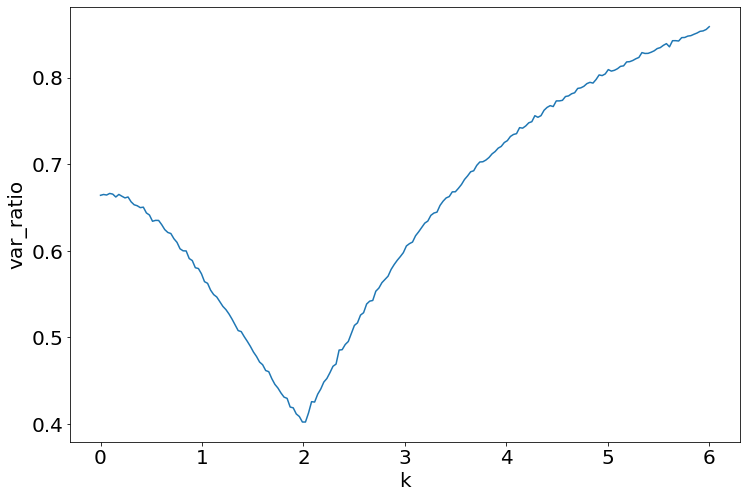

In [ ]:
plt.figure(figsize=(12, 8))
fontsize=20

ax = plt.axes()
plt.xlabel(r"k", fontsize=fontsize)
plt.ylabel(r"var_ratio", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

ax.plot(np.linspace(0, 6, 200), res_list)
print(f'при n = {n}')

Результаты полностью соответсвуют теории, именно в точке $\sqrt{n}=2$ первая главная компонента объясняет наименьшее количество дисперсии.

Из этого всего можно сделать такой практический вывод. Во-первых PCA не различает шум и нужную информацию, поэтому если величина шума в зависмых компонентах велика, то PCA не сможет избавиться от этих зависимых признаков. Тким образом, наличие большого количества сильно зашумленных признаков может привести к потере большого количества информации после применения PCA. Во-вторых, стоит нормализировать данные перед PCA, чтобы PCA не отдавал предпочтение признакам с большим шкалированием, мы не хотим этого, так как шкалирование никак не влияет на информативность признака.